In [4]:
import matplotlib.pyplot as plt

import os 
import sys
import numpy as np
import pandas as pd

import torch

import re
import glob
import h5py

from dataclasses import dataclass, InitVar

In [5]:
#import utilities from the automl package
base_path = os.getcwd()
sys.path.append(base_path)

import automl
from automl.models import VAE, ENC_M, ENC_M_dz
from automl.dataloaders import (
                                SequenceDataModule, 
                                Sequence_WT_DataModule,
                                EmbeddingsDataModule, 
                                Embeddings_WT_Dataset
)

/home/andrea/anaconda3/envs/automl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Brief Description of the input Ddatasets
The dataset contains two input sources: a .csv file containing  protein variants, mutated sequences, and experimental $\Delta \Delta G$ scores, along with a .pdb structure file for each protein id.  $\Delta \Delta G$ scores measure the free energy change for unfolding a protein variant, compared to that for unfolding the corresponding wild type. Aim of the project, is the prediction of this free energy change, for a given sequence. 

in the following section we take a closer look at the sequence specific data. 

## 1) Analysis of the input data



In [6]:
#loading the data 
data_dir = 'Data'
stability_df = pd.read_csv(os.path.join(data_dir,'mega_scale_ddg_single_mut_with_seq_no_con.csv'))
stability_df.head()

,pdbid,score,variant,aa_seq,aa_seq_full,chainid
0,1GYZ,0.228775,W1Q,QIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,SAGGSAQIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAV...,A
1,1GYZ,0.496896,W1E,EIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,SAGGSAEIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAV...,A
2,1GYZ,0.163002,W1N,NIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,SAGGSANIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAV...,A
3,1GYZ,0.209013,W1H,HIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,SAGGSAHIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAV...,A
4,1GYZ,0.407602,W1D,DIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,SAGGSADIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAV...,A


#### First we take a closer look at the score column i.e. our target variable values.

<Axes: ylabel='Frequency'>

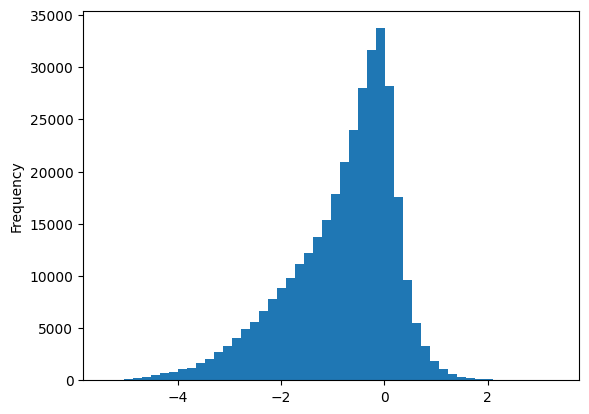

In [7]:
stability_df.score.plot.hist(bins=50)

 The score distribution is rather skewed. As we are dealing with relative free energies, the value of 0 corresponds to the wild type score. Clearly there are not many variants that lead to greater protein stability, whereas some variants can strongly destabilize the folded state. 

 This means that standard or minmax scaling will have the side effect of moving the maximum of the distribution away from zero. In principle one could attempt other transforms to create a more gaussian like distribution, however this  a) distorts the underlying physical interactions that lead to this distribution and b) leads to a different scaling of experimental uncertainties of the datapoints.  

 As an alternative we can use "half" of a standard scaler to reduce the distribution width of the negative part of the distribution to a (pseudo) std of 1. We do this by assuming a symmetrical distribution with mean at 0. For this one standard deviation can be calculated by using only the negative half of the distribution by $\sqrt (\sum (y²))$

<Axes: ylabel='Frequency'>

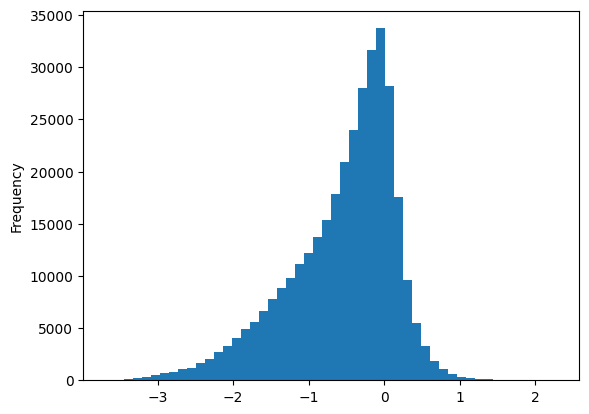

In [8]:
#create a pseudo std for the  negative tail for scaling. 
pseudo_std = np.sqrt(sum(np.power(stability_df[stability_df.score <=0]['score'],2))/len(stability_df[stability_df.score <=0]))
stability_df['score_scaled'] = stability_df['score']/pseudo_std
stability_df.score_scaled.plot.hist(bins=50)

The stability of a protein is closely linked to the probability of it's existence in the cell, denatured proteins are easily degraded by autophagy. Many high throughput assays for protein variants exploit this relation. In such assays it is assumed that stability is the only factor which can be inferred from number counts. (MAVE reference) 

Following this assumption, the probability of observing a given variant relative to the wt is $\propto \exp(-\Delta\Delta G)$. For modelling this could be used in the sampling probability for a variational autoencoder model. 

The distribution of probabilities: 

/tmp/ipykernel_3579406/2216696526.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


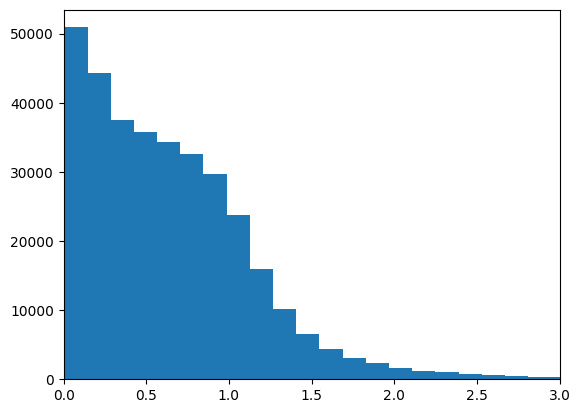

In [9]:
fig, ax = plt.subplots(1,1)

proba = np.exp(stability_df.score)
ax.hist(proba, bins=200)
ax.set_xlim(0,3)

fig.show()

#### Other Factors: sequence length and amino acid content 

72 30


<Axes: ylabel='Frequency'>

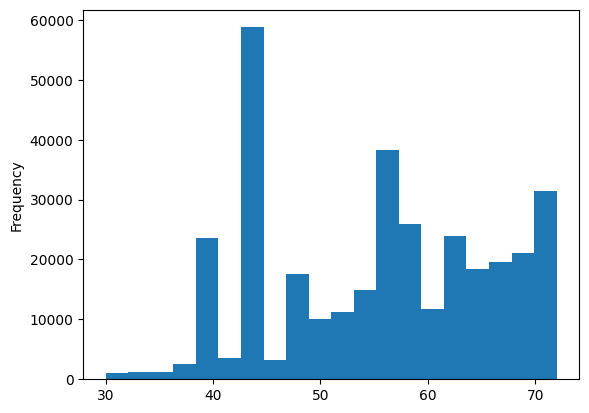

In [10]:
#get the range of sequence lengths and distribution
print(stability_df.aa_seq.apply(len).max(), stability_df.aa_seq.apply(len).min())
stability_df.aa_seq.apply(len).plot.hist(bins=20)

All protein sequences are comparatively short, between 30 and 70 AA. Meaning that array sizes are likely to remain managable. Short sequences will also most likey allow the use of smaller model sizes, because no very long range correlations have to be accounted for. 

20 amino acids found


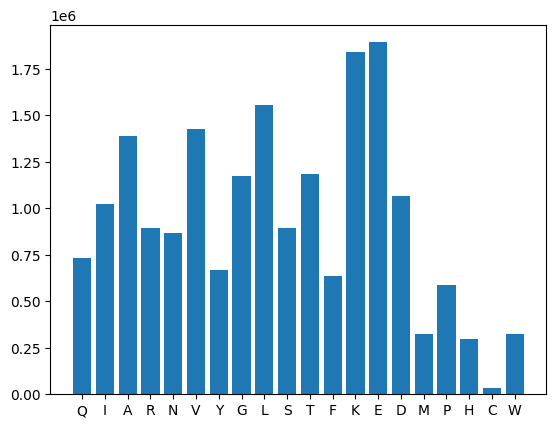

In [11]:
from collections import Counter
def compute_aminoacids_freq(df):
    freq_per_acid = Counter("".join(df["aa_seq"]))
    return dict(freq_per_acid)

amino_acids_freq = compute_aminoacids_freq(stability_df)
print( len(amino_acids_freq), 'amino acids found')
plt.bar(range(len(amino_acids_freq)), list(amino_acids_freq.values()), align='center')
plt.xticks(range(len(amino_acids_freq)), list(amino_acids_freq.keys()))

plt.show()

In [12]:
print('rarest AA: ', amino_acids_freq['C'])

rarest AA:  36018


No non standard Amino acids are present in the set. Even the least frequent has 36000 occurences.  

### Protein specific data split considerations: 

a random dataset split may lead to considerable data leaks, because mutations in the same position are likely to have correlated effects. 

Alternatively we can consider  a 'per residue' split or a 'per protein' split chould be considered. On the other hand, the latter would require models to perform a very high degree of extrapolation, which is likely not ideal as validation. However some proteins may be held out for testing on unseen data. 

## 2) Methods Review and Proposed Strategy

### Background

the task of predicting thermodynamic folding stability of proteins can be addressed by several approaches. These can be basedeither mainly on  (A) on the protein folded structures or (B) on the protein sequences, though both are not mutually exclusive and ideally information from both could be used to improve predictions as for example through the use of structural contact maps in training sequence based models, or, inversely the use of .

(A) Structure based approches are often physics based, i.e. they aim to predict the stability based on molecular interaction potentials. A frequently used approach are Free Energy Perturbation simulations (e.g.)) However such methods are still comaratively computationall expensive, even for small proteins, so that a scan of many variants requires extensive compute resources. 

(B) Methods based on sequence are typically information based, rather than trying to model physical properties, and aim to learn the underlying design principles from statistical information available in large biological databases. Many large advances have been made in the field of deep learning on proteins sequneces. Notable examples are the recent breakthroughs in solving the protein folding problem (Alphafold2 , ESM Fold, RosettaTX) which utilize tools from NLP.   
 
 In many case, the use of evolutionary data in the form of multy sequence alignment data (MSA) of related proteins from diverse species greatly increases model accuracy  On the other hand autoregressive models have proved valuable, especially for cases, in which limited to no MSA data is available. 

 As an alternative to the Deep Convollutional Networks usng dilated convolutions to capture long range context have had good success in learning underlying principles of protein sequences, for instance using an ensemble of CNN models to classify protein domain function and the engineering (ProtCNN) of new functional proteins (BioSeqVae) 
 
 Large models with millions of parameters, however even small neural network models with fully connected feed forward layers have achieved good predictive power for predicting effects of single variant mutations when trained. One example is the EVE model, a genartaive VAE model trained on sampling evolutionary data and calculate the odds ratio of observing a mutation wrt the wild type. A second model is MAVE_NN which embeds sequences with a feed forward NN and trains a non linear predictor to map the latent representation to target variable. 

 Both models are trained on single protein data, and given their simple architecture it is unlikely that they will generalize well to predicting, but represent a good starting point for model development to which more advanced encoder/ embedding architectures can be added.  

In all cases the cental key to modelling protein sequences is to learn an informative reduced demensionality represnetation of the sequence


## Protein language models

One of the top performing protein language models is the T5 ProtTrans (protein transformer) model
 ProtTrans: https://github.com/agemagician/ProtTrans
 ProtTrans embedding scripts: https://github.com/Rostlab/VESPA/blob/main/README.md

The advantage of using such models is that they do not require the engineering and fine tuning of features, but rather learn the input features based on large amounts of data  

## Strategy

A central challenge in developing deep learning models, is the vast space of parameters to tune and optimize. 
Therefore, here models are setup within  a framework that allow to adaptively add model components, and eaily iterate through training parameters . 

This Framework is defined in the automl package.

In this project two simple model architectures based on the MAVE-NN (https://github.com/jbkinney/mavenn), and EVE (https://github.com/OATML/EVE) Models. These can serve as a baseline for evaluating performance of more advanced models. 

Once simulations are running, and tuned, more advanced model components such as a ResNet CNN Encoder can easily be integrated, by ading it to the encoder directory and creating a corresponding config yaml that specifies the target function. 

Here, after basic model setup, we will explore the possibilities that embedding vectors generated by massive pretrained language models offer. 



## Preparing the Datasets for the proposed Models

Based on the above considerations, and potential model requirements we ... following outline: 

- pad the sequences to the same lenth (most models require constant input dimensions)
- take out a few proteins from training data for evaluation of model extrapolation
- create different data splits (i) random - for comparison, as this often done in the literature, (ii) per residu (iii) per protein
- create a few single protein sets, for quick optimization and comarison to protein specific models in the literature. 


In [13]:
from automl.dataloaders.utils import generate_dict_from_alphabet

#creating a index lookup table for aminoacids in the alphabet
protein_alphabet = "ACDEFGHIKLMNPQRSTVWY"
protein_AA_dict = generate_dict_from_alphabet(protein_alphabet)

In [14]:
from automl.dataloaders.utils import pad_sequence
#Padding all sequences to the same length

max_length = 72
seq_list = stability_df.aa_seq.to_list()
stability_df['padded_seq'] = [pad_sequence(s,max_length) for s in seq_list]

# and spliting the Variant specification to extract the WT AA as well as the position. 
# we'll use this to reconstruct the wild type sequence. 
matches_list = [re.findall('([A-Za-z])([0-9]+)([A-Za-z])', s)
                        for s in stability_df['variant']]

stability_df[['WT', 'pos', 'MUT']] = np.array(matches_list)[:].reshape(-1,3)

In [15]:
# For the per residue and per protein datasplits,
# collect info for each protein in the set and unique (protein,position)
#  assumption: single mutation data -> there is a unique wt sequence for each pdb id. 
# (in fact this is not strictly true )  

@dataclass
class protein:
    pdb_name: str
    wt: str 
    seq_len: int 

def make_WT (seq:str, pos:int, AA:str)->str:
    wt = seq[:pos-1] + AA + seq[pos:]
    return wt

proteins = stability_df.drop_duplicates(['pdbid'])[['pdbid','aa_seq','WT','MUT','pos' ]]
protein_list = []
for i,r in proteins.iterrows():
    wt= make_WT(r.aa_seq, int(r.pos), r.WT)
    protein_list.append(protein(pdb_name= r.pdbid, wt= wt,  seq_len=len(r.aa_seq)))

protein_position_pairs = [(p.pdb_name, i+1) for p in protein_list for i in range(p.seq_len)]

print(len(protein_list), 'unique protein pdb ids found')

310 unique protein pdb ids found


In [22]:
#add the corresponding padded wt sequence to each data line, this may serve as additional features
prot_dict = {p.pdb_name: pad_sequence(p.wt, max_length) for p in protein_list}

stability_df['wt'] = stability_df.pdbid.apply(lambda x: prot_dict[x] )

In [16]:
#save for reference and loading in other notebooks
import json

wt_dict = open(os.path.join(data_dir, 'wt_sequences.json'),'w')
json.dump({p.pdb_name: p.wt for p in protein_list}, wt_dict)

wt_dict.close()

Now we can create our different split datasets

In [18]:
from torch.utils.data import random_split

#get the total numbers for each split type
N_proteins = len(protein_list)
N_total_res_positions = len(protein_position_pairs)
N_mutations = len(stability_df)

# first withhold some (4) proteins from training completely
N_withheld = 4
protein_list_train, test_proteins = random_split(protein_list, [N_proteins-N_withheld, N_withheld])

name_list =  [tp.pdb_name for tp in test_proteins]
test_proteins_df = stability_df[stability_df['pdbid'].isin(name_list)]
protein_df = stability_df.query("pdbid not  in @name_list")

print(len(test_proteins_df), len(protein_df), len(stability_df))


3724 336054 339778


In [19]:
val_fraction = 0.1
test_fraction = 0.1

#create a column to pick unique pdbid - varian pairs so that we can split al variants of any position into the
#test or train set 
protein_df = protein_df.copy()
protein_df['pair_col'] = protein_df.apply(lambda x: x.pdbid+'_'+x.pos, axis=1)

#define split methods
def split_numbers(N_total, fractions): 
    frac_list = [int(N_total*f ) for f in fractions]
    
    return tuple([N_total-sum(frac_list)] + frac_list)

def split_random(df:pd.DataFrame, val_fract: float=0., test_fract:float=0.)-> list:
    N_train, N_val, N_test = split_numbers(len(df), [val_fract, test_fract])

    i1, i2, i3 = random_split(df.index, [N_train, N_val, N_test])  
    return df[df.index.isin(list(i1))], df[df.index.isin(list(i2))], df[df.index.isin(list(i3))]
    
def split_per_residue(df, pairlist, val_fract: float=0., test_fract:float=0.):
    N_train, N_val, N_test = split_numbers(len(pairlist), [val_fract, test_fract])

    i1, i2, i3 = random_split(pairlist, [N_train, N_val, N_test])  
        
    i1= [t[0]+'_'+str(t[1]) for t in list(i1)]
    i2= [t[0]+'_'+str(t[1]) for t in list(i2)]
    i3= [t[0]+'_'+str(t[1]) for t in list(i3)]

    return df[df.pair_col.isin(i1)], df[df.pair_col.isin(i2)],df[df.pair_col.isin(i3)]

def split_per_protein(df, proteins, val_fract: float=0., test_fract:float=0.):
    N_train, N_val, N_test = split_numbers(len(proteins), [val_fract, test_fract])

    i1, i2, i3 = random_split(proteins, [N_train, N_val, N_test])  
    i1 = [i.pdb_name for i in list(i1)]
    i2 = [i.pdb_name for i in list(i2)]
    i3 = [i.pdb_name for i in list(i3)]

    return df[df.pdbid.isin(i1)],df[df.pdbid.isin(i2)],df[df.pdbid.isin(i3)]
    

In [20]:
#random split data
df_train_rand, df_val_rand, df_test_rand = split_random(protein_df, val_fraction, test_fraction)
print('random split dataframe lengths:', len(df_train_rand), len(df_val_rand), len(df_test_rand))

#per residue split of data
df_train_res, df_val_res, df_test_res = split_per_residue(protein_df, protein_position_pairs, val_fraction, test_fraction)
print('by residue dataframe lengths:', len(df_train_res), len(df_val_res), len(df_test_res))

#per protein split of data 
df_train_prot, df_val_prot, df_test_prot = split_per_protein(protein_df, protein_list_train, val_fraction, test_fraction)
print('by protein dataframe lengths:', len(df_train_prot), len(df_val_prot), len(df_test_prot))

random split dataframe lengths: 268844 33605 33605
by residue dataframe lengths: 269949 33109 32996
by protein dataframe lengths: 272602 32259 31193


Preparing the data to be handled by the automl dataloaders.- these expect a 'y' and a 'seq' column

In [18]:
def dataframe_prep(df:pd.DataFrame, cols:list[str] = ['pdbid','score','padded_seq', 'wt'], csv_file:str = 'data.csv', scaler = 1.0):
    """preprocess and save dataframe compatible with dataloader
    Args:
        df (pd.DataFrame): input data
        cols (list, optional): columns to include. Must include "score" and "padded_seq". Defaults to ['pdbid','score','padded_seq'].
        csv_file (str, optional): output file name. Defaults to 'data.csv'.
    """
    df = df[cols].copy() 
    df.rename(columns={'padded_seq':'seq'}, inplace=True)
    df['y'] = df.score/scaler
    df.to_csv(csv_file)

In [21]:
#prepare and save all the data_sets
data_sets = [df_train_rand, df_val_rand, df_test_rand, 
             df_train_res, df_val_res, df_test_res, 
             df_train_prot, df_val_prot, df_test_prot, 
             test_proteins_df]

csv_names = ["train_data_rand.csv", "val_data_rand.csv", "test_data_rand.csv", 
            "train_data_res.csv", "val_data_res.csv", "test_data_res.csv",  
             "train_data_prot.csv", "val_data_prot.csv", "test_data_prot.csv", 
             "test_proteins_data.csv"]

#scaling the scores by the pseudo std calculated above. 
for df, csv in zip(data_sets,csv_names):
    outfile = os.path.join(data_dir,'data_sets', csv)
    dataframe_prep(df, csv_file=outfile, scaler=pseudo_std)

In [31]:
#ead datasets back if needed 
df_train_rand = pd.read_csv(os.path.join(data_dir, 'data_sets', 'train_data_rand.csv'), index_col= 0)
df_val_rand = pd.read_csv(os.path.join(data_dir, 'data_sets', 'val_data_rand.csv'), index_col= 0)
df_test_rand = pd.read_csv(os.path.join(data_dir, 'data_sets', 'test_data_rand.csv'), index_col= 0)

df_train_res = pd.read_csv(os.path.join(data_dir, 'data_sets', 'train_data_res.csv'), index_col= 0)
df_val_res = pd.read_csv(os.path.join(data_dir,'data_sets', 'val_data_res.csv'), index_col= 0)
df_test_res = pd.read_csv(os.path.join(data_dir, 'data_sets','test_data_res.csv'), index_col= 0)

df_train_prot = pd.read_csv(os.path.join(data_dir, 'data_sets','train_data_prot.csv'), index_col= 0)
df_val_prot = pd.read_csv(os.path.join(data_dir, 'data_sets','val_data_prot.csv'), index_col= 0)
df_test_prot = pd.read_csv(os.path.join(data_dir, 'data_sets','test_data_prot.csv'), index_col= 0)

test_proteins_df = pd.read_csv(os.path.join(data_dir, 'data_sets','test_proteins_data.csv'), index_col= 0)

In [32]:
single_protein_names = ['1MJC', '1JIC', '1CSQ', '1O6X', '1MHN']

for p in single_protein_names: 
    df_train_rand[df_train_rand.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'train_rand_' + p +'.csv'))
    df_train_res[df_train_res.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'train_res_' + p +'.csv'))
    df_val_rand[df_val_rand.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'val_rand_' + p +'.csv'))
    df_val_res[df_val_res.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'val_res_' + p +'.csv'))
    df_test_rand[df_test_rand.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'test_rand_' + p +'.csv'))
    df_test_res[df_test_res.pdbid == p].to_csv(os.path.join(data_dir,'data_sets', 'test_res_' + p +'.csv'))

With these datasets we can now proceed to trane some baseline models